# ML Experiments

In [101]:
from __future__ import annotations
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

In [2]:
# NOTE: This library isn't yet available publicly!
from nd_learn.api import *
from nd_learn.api.sklearn import SKLEst, SKLOp

import lightgbm as lgb

In [3]:
from m5 import __data__
from m5.data.ready import load_ds, path_ds
# from m5.data.prep import *
# from m5.data.raw import calendar, sell_prices, sales_train_eval, sales_train_valid, sample_submission

In [4]:
from m5.metrics import get_weights, get_rmsse, get_wrmsse, wrmsse_per_level, wrmsse_total

## Prepare Data

### Load

In [5]:
ds_all = load_ds()

In [6]:
ds = ds_all.where(ds_all['historic'], drop=True).drop(["historic", "future"])
# Fix dtype changes due to "where" mask
vars_int = ['sales', 'wday', 'month', 'year', 'event', 'snap']
for v in vars_int:
    ds[v] = ds[v].astype(int)
ds

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
Data variables:
    sales       (item_id, store_id, date) int64 3 0 0 1 4 2 0 ... 0 0 0 0 0 0 0
    price       (item_id, store_id, date) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

### Fixes and checks

Fill the price for when we don't know it:

In [7]:
ds['price'] = ds['price'].ffill(dim="date").bfill(dim="date")

Check that all values are nonnegative:

In [8]:
(ds<0).sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sales    int64 0
    price    int64 0
    wday     int64 0
    month    int64 0
    year     int64 0
    event    int64 0
    snap     int64 0

Check that we don't have any nulls in our data:

In [9]:
ds.isnull().sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sales    int64 0
    price    int64 0
    wday     int64 0
    month    int64 0
    year     int64 0
    event    int64 0
    snap     int64 0

### Create Features

We will calculate features now, to avoid having to create a pipeline.
(It's not available in nd_learn yet, and I don't have enough time to code it)

In [10]:
# raw_ds = ds.copy()

We can't use target lags directly, because we must do a prediction many steps ahead!

Categorical features (as integers, because LightGBM can encode them natively)

In [11]:
ds.coords['category'] = np.unique(ds['cat_id'])
ds.coords['department'] = np.unique(ds['dept_id'])
ds.coords['state'] = np.unique(ds['state_id'])
ds.coords['store'] = np.unique(ds['store_id'])
ds.coords['item'] = np.unique(ds['item_id'])

In [12]:
def get_feat(ds, a: str, b: str) -> xr.DataArray:
    q = (ds[a] == ds[b])
    q.coords[b] = np.arange(len(q[b]))
    return q.idxmax(dim=b)

In [13]:
ds["feat_category"] = get_feat(ds, 'cat_id', 'category')
ds["feat_department"] = get_feat(ds, 'dept_id', 'department')
ds["feat_item"] = get_feat(ds, 'item_id', 'item')
ds["feat_state"] = get_feat(ds, 'state_id', 'state')
ds["feat_store"] = get_feat(ds, 'store_id', 'store')

Event features (there can be more than 1 event, but we'll take the first one & save number of them)

In [14]:
new_ev = xr.Dataset(
    coords={
        "event_name": ("event_name", ["(No Event)"]),
        "event_type": ("event_name", ["(No Event)"]),
    },
)
ds = xr.merge([new_ev, ds])

In [15]:
ds['n_events'] = ds['event'].sum(dim='event_name')
ds['event_ohe'] = ds['event'].fillna(ds['n_events']==0).astype(int)
del ds['event']

In [16]:
ds['feat_event'] = (ds['event_ohe'] * ds['event_name']).any(dim='event_name')
ds['feat_event'] = ds['feat_event'].where(ds['n_events'], other=np.nan)
q = get_feat(ds, 'feat_event', 'event_name')
q = q.where(~ds['feat_event'].isnull(), 0)
ds['feat_event'] = q

In [17]:
ds.coords['etype'] = np.unique(ds['event_type'])

In [18]:
ds['feat_etype'] = (ds['event_ohe'] * ds['event_type']).any(dim='event_name')
ds['feat_etype'] = ds['feat_etype'].where(ds['n_events'], other=np.nan)
q = get_feat(ds, 'feat_etype', 'etype')
q = q.where(~ds['feat_etype'].isnull(), 0)
ds['feat_etype'] = q

Remove `"event"/"event_ohe"` due to memory concerns :)

In [19]:
del ds['event_ohe']  # This is problematic in terms of memory usage

Lead/Lag for nearby events (e.g. people buy up for events):

In [20]:
leads = [1, 2]
_ds_leads = []
for i in leads:
    _ds_leads.append(ds["n_events"].shift(date=-i, fill_value=0).astype(int).expand_dims({"lead": i}))
ds["n_events_future"] = xr.concat(_ds_leads, dim="lead")
    
lags = [1]
_ds_lags = []
for i in lags:
    _ds_lags.append(ds["n_events"].shift(date=i, fill_value=0).astype(int).expand_dims({"lag": i}))
ds["n_events_past"] = xr.concat(_ds_lags, dim="lag")

Get sales for 1 year ago

In [21]:
_r1 = ds['sales'].shift({"date": 365}, fill_value=0).rolli ng({'date': 7}, min_periods=1, center=False)

In [22]:
ds['sales_year_ago_mean'] = _r1.mean()
ds['sales_year_ago_max'] = _r1.max()
ds['sales_year_ago_min'] = _r1.min()

Get price for 1 year ago

In [23]:
_r2 = ds['price'].shift({"date": 365}).bfill(dim="date").rolling({'date': 7}, min_periods=1, center=False)

In [24]:
ds['price_year_ago_mean'] = _r2.mean()
ds['price_year_ago_max'] = _r2.max()
ds['price_year_ago_min'] = _r2.min()

Remove "year" to prevent some overfitting

In [25]:
del ds["year"]

Preview our dataset

In [26]:
ds

<xarray.Dataset>
Dimensions:              (category: 3, date: 1941, department: 7, etype: 5, event_name: 31, item: 3049, item_id: 3049, lag: 1, lead: 3, state: 3, store: 10, store_id: 10)
Coordinates:
  * event_name           (event_name) object '(No Event)' ... 'VeteransDay'
    event_type           (event_name) object '(No Event)' ... 'National'
  * item_id              (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id               (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD'
    dept_id              (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id             (store_id) object 'CA_1' 'CA_2' ... 'WI_2' 'WI_3'
    state_id             (store_id) object 'CA' 'CA' 'CA' ... 'WI' 'WI' 'WI'
  * date                 (date) datetime64[ns] 2011-01-29 ... 2016-05-22
  * category             (category) object 'FOODS' 'HOBBIES' 'HOUSEHOLD'
  * department           (department) object 'FOODS_1' ... 'HOUSEHOLD_2'
  * state                (state) object 'CA' 'TX' 'WI'
  * store                (store) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
  * item                 (item) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
  * etype                (etype) object '(No Event)' 'Cultural' ... 'Sporting'
Dimensions without coordinates: lag, lead
Data variables:
    sales                (item_id, store_id, date) int64 3 0 0 1 4 ... 0 0 0 0 0
    price                (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    wday                 (date) int64 1 2 3 4 5 6 7 1 2 3 ... 1 2 3 4 5 6 7 1 2
    month                (date) int64 1 1 1 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5
    snap                 (date, store_id) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    feat_category        (item_id) int64 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2
    feat_department      (item_id) int64 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6 6
    feat_item            (item_id) int64 0 1 2 3 4 ... 3044 3045 3046 3047 3048
    feat_state           (store_id) int64 0 0 0 0 1 1 1 2 2 2
    feat_store           (store_id) int64 0 1 2 3 4 5 6 7 8 9
    n_events             (date) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    feat_event           (date) int64 0 0 0 0 0 0 0 0 27 0 ... 0 0 0 0 0 0 0 0 0
    feat_etype           (date) int64 0 0 0 0 0 0 0 0 4 0 ... 0 0 0 0 0 0 0 0 0
    n_events_future      (lead, date) int64 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 0 0
    n_events_past        (lag, date) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    sales_year_ago_mean  (item_id, store_id, date) float64 0.0 0.0 ... 0.2857
    sales_year_ago_max   (item_id, store_id, date) float64 0.0 0.0 ... 1.0 1.0
    sales_year_ago_min   (item_id, store_id, date) float64 0.0 0.0 ... 0.0 0.0
    price_year_ago_mean  (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    price_year_ago_max   (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    price_year_ago_min   (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94

### Split into training and validation

Let's train until 2016, and validate on the last few months.

In [27]:
dates_train = slice(None, '2015-12-31')
dates_valid = slice('2016-01-01', None)

ds_train = ds.sel({"date": slice(None, '2015-12-31')})

## ML Model

### Fit

Select categorical feature names

In [28]:
my_cats = [
    "wday",
    "month",
    "feat_category",
    "feat_department",
    "feat_item",
    "feat_state",
    "feat_store",
    "feat_event",
    "feat_etype",
]

#### Optimize

In [29]:
import optuna

In [197]:
path_study = __data__ / "optimize_lgb.db"

In [198]:
study = optuna.create_study(storage=f"sqlite:///{path_study}", study_name="optimize_lgb", load_if_exists=True)

[I 2021-07-08 03:42:46,026] Using an existing study with name 'optimize_lgb' instead of creating a new one.


Train-validation using 2013 thru 2015 data

In [66]:
xy_01 = ds_train.sel(date=slice("2013-01-01", "2014-12-31"))
xy_02 = ds_train.sel(date=slice("2015-01-01", "2015-12-31"))

In [67]:
def objective(trial: optuna.Trial) -> float:
    """Optimization objective."""

    l_est = lgb.LGBMRegressor(
        objective="poisson",
        n_estimators=trial.suggest_int("n_estimators", 500, 3000, step=500),
        # max_depth=trial.suggest_categorical("max_depth", [4, 5, -1]),
        colsample_bytree=trial.suggest_uniform("colsample_bytree", 0.8, 1.0),
        lambda_l1=trial.suggest_loguniform("lambda_l1", 0.01, 1.0),
        lambda_l2=trial.suggest_loguniform("lambda_l2", 0.01, 1.0),
        num_leaves=trial.suggest_int("num_leaves", 30, 128),
        # min_child_samples=trial.suggest_int("min_child_samples", 5, 100, step=5),
        # categorical_feature='name:'+','.join(my_cats),
    )
    est = SKLEst(
        l_est, targets="sales", extra_fit_kwargs={"categorical_feature": my_cats}
    )
    mdl = est.fit(xy_01)
    xy_02_hat = mdl.transform(xy_02)
    res = wrmsse_total(xy_01, xy_02_hat)
    return res

In [ ]:
n_new_trials = 0
if n_new_trials > 0:
    study.optimize(objective, n_trials=n_new_trials, gc_after_trial=True)

[LightGBM] [Warning] lambda_l1 is set=0.027079522805206306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.027079522805206306
[LightGBM] [Warning] lambda_l2 is set=0.01112334152106312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01112334152106312


[I 2021-07-07 03:22:20,891] Trial 27 finished with value: 0.8916320094179125 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9188653163726971, 'lambda_l1': 0.027079522805206306, 'lambda_l2': 0.01112334152106312, 'num_leaves': 88}. Best is trial 12 with value: 0.8842783252263767.


[LightGBM] [Warning] lambda_l1 is set=0.017765929265380263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017765929265380263
[LightGBM] [Warning] lambda_l2 is set=0.010014031424352674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010014031424352674


[I 2021-07-07 03:29:06,672] Trial 28 finished with value: 0.8784441585154622 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8910503786239161, 'lambda_l1': 0.017765929265380263, 'lambda_l2': 0.010014031424352674, 'num_leaves': 83}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.01586461783651217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01586461783651217
[LightGBM] [Warning] lambda_l2 is set=0.03671652116609196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03671652116609196


[I 2021-07-07 03:38:34,325] Trial 29 finished with value: 0.8960895612300684 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.8926791523402974, 'lambda_l1': 0.01586461783651217, 'lambda_l2': 0.03671652116609196, 'num_leaves': 97}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.010040793804169112, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010040793804169112
[LightGBM] [Warning] lambda_l2 is set=0.014981452240257908, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014981452240257908


[I 2021-07-07 03:45:13,184] Trial 30 finished with value: 0.8824376118496593 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8858809263735252, 'lambda_l1': 0.010040793804169112, 'lambda_l2': 0.014981452240257908, 'num_leaves': 76}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.011453334604985717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011453334604985717
[LightGBM] [Warning] lambda_l2 is set=0.02300771785278963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02300771785278963


[I 2021-07-07 03:54:13,934] Trial 31 finished with value: 0.8867176204360354 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.8862309269203263, 'lambda_l1': 0.011453334604985717, 'lambda_l2': 0.02300771785278963, 'num_leaves': 80}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.018955713931860668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018955713931860668
[LightGBM] [Warning] lambda_l2 is set=0.010206675021862949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010206675021862949


[I 2021-07-07 04:05:18,579] Trial 32 finished with value: 0.8937295041320326 and parameters: {'n_estimators': 1500, 'colsample_bytree': 0.9310991449340986, 'lambda_l1': 0.018955713931860668, 'lambda_l2': 0.010206675021862949, 'num_leaves': 72}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.01001827637275772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01001827637275772
[LightGBM] [Warning] lambda_l2 is set=0.013928139894928068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013928139894928068


[I 2021-07-07 04:11:51,360] Trial 33 finished with value: 0.8925479412521712 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8821010053624602, 'lambda_l1': 0.01001827637275772, 'lambda_l2': 0.013928139894928068, 'num_leaves': 65}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.03217896475268711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03217896475268711
[LightGBM] [Warning] lambda_l2 is set=0.03207475850993759, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03207475850993759


[I 2021-07-07 04:20:38,123] Trial 34 finished with value: 0.8953399905876238 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.921198681247489, 'lambda_l1': 0.03217896475268711, 'lambda_l2': 0.03207475850993759, 'num_leaves': 55}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.013896562264216473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013896562264216473
[LightGBM] [Warning] lambda_l2 is set=0.7491707077150723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7491707077150723


[I 2021-07-07 04:32:00,856] Trial 35 finished with value: 0.8985323015812985 and parameters: {'n_estimators': 1500, 'colsample_bytree': 0.8619273989386105, 'lambda_l1': 0.013896562264216473, 'lambda_l2': 0.7491707077150723, 'num_leaves': 81}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.020563904071672027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020563904071672027
[LightGBM] [Warning] lambda_l2 is set=0.08225507154840017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08225507154840017


[I 2021-07-07 04:39:05,633] Trial 36 finished with value: 0.895641129049689 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8386418873848773, 'lambda_l1': 0.020563904071672027, 'lambda_l2': 0.08225507154840017, 'num_leaves': 110}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.061094663631192626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.061094663631192626
[LightGBM] [Warning] lambda_l2 is set=0.017660409406342052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017660409406342052


[I 2021-07-07 04:45:55,411] Trial 37 finished with value: 0.8806849012313543 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8578546948855026, 'lambda_l1': 0.061094663631192626, 'lambda_l2': 0.017660409406342052, 'num_leaves': 91}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.038073284877018276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.038073284877018276
[LightGBM] [Warning] lambda_l2 is set=0.02014588520367121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02014588520367121


[I 2021-07-07 04:52:40,470] Trial 38 finished with value: 0.8823581858647942 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9010029097998209, 'lambda_l1': 0.038073284877018276, 'lambda_l2': 0.02014588520367121, 'num_leaves': 81}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.12925945859268403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12925945859268403
[LightGBM] [Warning] lambda_l2 is set=0.01977004472879456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01977004472879456


[I 2021-07-07 04:59:27,664] Trial 39 finished with value: 0.8846342010623941 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8986585935373956, 'lambda_l1': 0.12925945859268403, 'lambda_l2': 0.01977004472879456, 'num_leaves': 84}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.04859541153828876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04859541153828876
[LightGBM] [Warning] lambda_l2 is set=0.014474557019624634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014474557019624634


[I 2021-07-07 05:08:54,345] Trial 40 finished with value: 0.8891020472056766 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.8254037672926663, 'lambda_l1': 0.04859541153828876, 'lambda_l2': 0.014474557019624634, 'num_leaves': 97}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.11865793902205592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11865793902205592
[LightGBM] [Warning] lambda_l2 is set=0.3785401035116453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3785401035116453


[I 2021-07-07 05:22:52,139] Trial 41 finished with value: 0.9035429627471876 and parameters: {'n_estimators': 2000, 'colsample_bytree': 0.8648554875335033, 'lambda_l1': 0.11865793902205592, 'lambda_l2': 0.3785401035116453, 'num_leaves': 90}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.03590540227626426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03590540227626426
[LightGBM] [Warning] lambda_l2 is set=0.1475949418787609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1475949418787609


[I 2021-07-07 05:29:50,572] Trial 42 finished with value: 0.8936569737303545 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8006726099014498, 'lambda_l1': 0.03590540227626426, 'lambda_l2': 0.1475949418787609, 'num_leaves': 110}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.06361926300751507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06361926300751507
[LightGBM] [Warning] lambda_l2 is set=0.013115861958570304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013115861958570304


[I 2021-07-07 05:38:54,987] Trial 43 finished with value: 0.8869329787665133 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.8486231264266343, 'lambda_l1': 0.06361926300751507, 'lambda_l2': 0.013115861958570304, 'num_leaves': 77}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.09901166084625858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09901166084625858
[LightGBM] [Warning] lambda_l2 is set=0.04527785060425012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04527785060425012


[I 2021-07-07 05:45:39,630] Trial 44 finished with value: 0.8798434282847317 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8873132518984334, 'lambda_l1': 0.09901166084625858, 'lambda_l2': 0.04527785060425012, 'num_leaves': 83}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.10488503014617909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10488503014617909
[LightGBM] [Warning] lambda_l2 is set=0.05477735773864383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05477735773864383


[I 2021-07-07 05:54:57,217] Trial 45 finished with value: 0.8887383353178339 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.9041769161273128, 'lambda_l1': 0.10488503014617909, 'lambda_l2': 0.05477735773864383, 'num_leaves': 83}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.3256854574573159, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3256854574573159
[LightGBM] [Warning] lambda_l2 is set=0.06631352082418232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06631352082418232


[I 2021-07-07 06:11:52,180] Trial 46 finished with value: 0.9087472490928143 and parameters: {'n_estimators': 2500, 'colsample_bytree': 0.8743298954905742, 'lambda_l1': 0.3256854574573159, 'lambda_l2': 0.06631352082418232, 'num_leaves': 96}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.09597620481109378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09597620481109378
[LightGBM] [Warning] lambda_l2 is set=0.04508929974069166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04508929974069166


[I 2021-07-07 06:18:30,393] Trial 47 finished with value: 0.8823046649207518 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8944773287826429, 'lambda_l1': 0.09597620481109378, 'lambda_l2': 0.04508929974069166, 'num_leaves': 67}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.16524775359407412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16524775359407412
[LightGBM] [Warning] lambda_l2 is set=0.04313888233786257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04313888233786257


[I 2021-07-07 06:25:06,703] Trial 48 finished with value: 0.9113540217050659 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.890469465236612, 'lambda_l1': 0.16524775359407412, 'lambda_l2': 0.04313888233786257, 'num_leaves': 69}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.1660572204115945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1660572204115945
[LightGBM] [Warning] lambda_l2 is set=0.12397855941080213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12397855941080213


[I 2021-07-07 06:31:39,553] Trial 49 finished with value: 0.8837836802727542 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8654693292408603, 'lambda_l1': 0.1660572204115945, 'lambda_l2': 0.12397855941080213, 'num_leaves': 69}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.09835488259363875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09835488259363875
[LightGBM] [Warning] lambda_l2 is set=0.02728747251112072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02728747251112072


[I 2021-07-07 06:38:07,911] Trial 50 finished with value: 0.8910061376071415 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8792680953457757, 'lambda_l1': 0.09835488259363875, 'lambda_l2': 0.02728747251112072, 'num_leaves': 59}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.2567983090185883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2567983090185883
[LightGBM] [Warning] lambda_l2 is set=0.041945826466292434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.041945826466292434


[I 2021-07-07 06:44:52,734] Trial 51 finished with value: 0.8887780234303574 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8994484811058902, 'lambda_l1': 0.2567983090185883, 'lambda_l2': 0.041945826466292434, 'num_leaves': 87}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.9191657302129893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9191657302129893
[LightGBM] [Warning] lambda_l2 is set=0.09671250624113091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09671250624113091


[I 2021-07-07 06:53:50,609] Trial 52 finished with value: 0.893429240320803 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.9357178732161828, 'lambda_l1': 0.9191657302129893, 'lambda_l2': 0.09671250624113091, 'num_leaves': 73}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.5805182190102006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5805182190102006
[LightGBM] [Warning] lambda_l2 is set=0.029049857594370704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029049857594370704


[I 2021-07-07 07:00:39,805] Trial 53 finished with value: 0.8812721940440874 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9212038324406374, 'lambda_l1': 0.5805182190102006, 'lambda_l2': 0.029049857594370704, 'num_leaves': 80}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.5941764398943157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5941764398943157
[LightGBM] [Warning] lambda_l2 is set=0.0507022526049532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0507022526049532


[I 2021-07-07 07:07:31,273] Trial 54 finished with value: 0.9036093643309348 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9235022325807691, 'lambda_l1': 0.5941764398943157, 'lambda_l2': 0.0507022526049532, 'num_leaves': 101}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.6732699424855313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6732699424855313
[LightGBM] [Warning] lambda_l2 is set=0.029902303682064018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029902303682064018


[I 2021-07-07 07:16:02,448] Trial 55 finished with value: 0.9044917934356552 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.9481515739799761, 'lambda_l1': 0.6732699424855313, 'lambda_l2': 0.029902303682064018, 'num_leaves': 50}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.15538884538996425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15538884538996425
[LightGBM] [Warning] lambda_l2 is set=0.06971376128005095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06971376128005095


[I 2021-07-07 07:22:38,663] Trial 56 finished with value: 0.889428456233967 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8282395150554018, 'lambda_l1': 0.15538884538996425, 'lambda_l2': 0.06971376128005095, 'num_leaves': 64}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.08966407383361606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08966407383361606
[LightGBM] [Warning] lambda_l2 is set=0.019911039142586223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019911039142586223


[I 2021-07-07 07:29:24,261] Trial 57 finished with value: 0.8845917846011931 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.90592354676511, 'lambda_l1': 0.08966407383361606, 'lambda_l2': 0.019911039142586223, 'num_leaves': 80}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.06506394136229654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06506394136229654
[LightGBM] [Warning] lambda_l2 is set=0.02334553987612755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02334553987612755


[I 2021-07-07 07:36:08,036] Trial 58 finished with value: 0.8798400518585331 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9138718896334965, 'lambda_l1': 0.06506394136229654, 'lambda_l2': 0.02334553987612755, 'num_leaves': 84}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.04515521274626516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04515521274626516
[LightGBM] [Warning] lambda_l2 is set=0.02509027755844444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02509027755844444


[I 2021-07-07 07:43:02,981] Trial 59 finished with value: 0.8970111961549182 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.915726688988914, 'lambda_l1': 0.04515521274626516, 'lambda_l2': 0.02509027755844444, 'num_leaves': 92}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.06529016811273719, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06529016811273719
[LightGBM] [Warning] lambda_l2 is set=0.03607252342462478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03607252342462478


[I 2021-07-07 07:49:46,701] Trial 60 finished with value: 0.8847845254721086 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9306746840038332, 'lambda_l1': 0.06529016811273719, 'lambda_l2': 0.03607252342462478, 'num_leaves': 85}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.056841321560514725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.056841321560514725
[LightGBM] [Warning] lambda_l2 is set=0.039569515454028134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039569515454028134


[I 2021-07-07 07:59:01,253] Trial 61 finished with value: 0.8965983179590206 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.9653734251198964, 'lambda_l1': 0.056841321560514725, 'lambda_l2': 0.039569515454028134, 'num_leaves': 89}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.22560111190038648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22560111190038648
[LightGBM] [Warning] lambda_l2 is set=0.05004295241450988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05004295241450988


[I 2021-07-07 08:05:40,803] Trial 62 finished with value: 0.8830594361063251 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9104277284102237, 'lambda_l1': 0.22560111190038648, 'lambda_l2': 0.05004295241450988, 'num_leaves': 75}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.13047724245829348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13047724245829348
[LightGBM] [Warning] lambda_l2 is set=0.028191690912026723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028191690912026723


[I 2021-07-07 08:12:15,221] Trial 63 finished with value: 0.8830154158474522 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9421415228204395, 'lambda_l1': 0.13047724245829348, 'lambda_l2': 0.028191690912026723, 'num_leaves': 68}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.07065542308207921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07065542308207921
[LightGBM] [Warning] lambda_l2 is set=0.01733497048322363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01733497048322363


[I 2021-07-07 08:20:58,990] Trial 64 finished with value: 0.890325816122434 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.9249944557294051, 'lambda_l1': 0.07065542308207921, 'lambda_l2': 0.01733497048322363, 'num_leaves': 59}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.1160299015841129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1160299015841129
[LightGBM] [Warning] lambda_l2 is set=0.0235886555166044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0235886555166044


[I 2021-07-07 08:27:46,389] Trial 65 finished with value: 0.8950430671940227 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8866381530813521, 'lambda_l1': 0.1160299015841129, 'lambda_l2': 0.0235886555166044, 'num_leaves': 94}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.08737101255387494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08737101255387494
[LightGBM] [Warning] lambda_l2 is set=0.012424391595290086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012424391595290086


[I 2021-07-07 08:36:49,547] Trial 66 finished with value: 0.8877619883516125 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.87111752803364, 'lambda_l1': 0.08737101255387494, 'lambda_l2': 0.012424391595290086, 'num_leaves': 79}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.04218838552075667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04218838552075667
[LightGBM] [Warning] lambda_l2 is set=0.020922287991137357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020922287991137357


[I 2021-07-07 08:43:32,462] Trial 67 finished with value: 0.8809694953495244 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8934777999757999, 'lambda_l1': 0.04218838552075667, 'lambda_l2': 0.020922287991137357, 'num_leaves': 83}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.056487422779285014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.056487422779285014
[LightGBM] [Warning] lambda_l2 is set=0.03133959981901751, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03133959981901751


[I 2021-07-07 08:50:17,635] Trial 68 finished with value: 0.8816782825730564 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9129181410204925, 'lambda_l1': 0.056487422779285014, 'lambda_l2': 0.03133959981901751, 'num_leaves': 84}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.0282782364459426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0282782364459426
[LightGBM] [Warning] lambda_l2 is set=0.03189656349118662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03189656349118662


[I 2021-07-07 08:57:06,624] Trial 69 finished with value: 0.8906284408031119 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.91273207573336, 'lambda_l1': 0.0282782364459426, 'lambda_l2': 0.03189656349118662, 'num_leaves': 87}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.053237987045331864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.053237987045331864
[LightGBM] [Warning] lambda_l2 is set=0.016952701457372918, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016952701457372918


[I 2021-07-07 09:03:51,529] Trial 70 finished with value: 0.8816387247048537 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9276830499685059, 'lambda_l1': 0.053237987045331864, 'lambda_l2': 0.016952701457372918, 'num_leaves': 83}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.04221100895315875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04221100895315875
[LightGBM] [Warning] lambda_l2 is set=0.01699462921517101, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01699462921517101


[I 2021-07-07 09:10:29,848] Trial 71 finished with value: 0.8815282589563666 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9297567108978048, 'lambda_l1': 0.04221100895315875, 'lambda_l2': 0.01699462921517101, 'num_leaves': 72}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.04150267527164408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04150267527164408
[LightGBM] [Warning] lambda_l2 is set=0.021157552103049464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021157552103049464


[I 2021-07-07 09:17:06,754] Trial 72 finished with value: 0.8871188554886196 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.940748707961487, 'lambda_l1': 0.04150267527164408, 'lambda_l2': 0.021157552103049464, 'num_leaves': 72}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.07160877730922947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07160877730922947
[LightGBM] [Warning] lambda_l2 is set=0.011894517899570765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011894517899570765


[I 2021-07-07 09:32:55,565] Trial 73 finished with value: 0.9071101809503425 and parameters: {'n_estimators': 2500, 'colsample_bytree': 0.8816983468102355, 'lambda_l1': 0.07160877730922947, 'lambda_l2': 0.011894517899570765, 'num_leaves': 78}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.030597952293121355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030597952293121355
[LightGBM] [Warning] lambda_l2 is set=0.01551194283322394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01551194283322394


[I 2021-07-07 09:39:49,080] Trial 74 finished with value: 0.8969905082064825 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.958369646558292, 'lambda_l1': 0.030597952293121355, 'lambda_l2': 0.01551194283322394, 'num_leaves': 91}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.04424675904181691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04424675904181691
[LightGBM] [Warning] lambda_l2 is set=0.02374607419242611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02374607419242611


[I 2021-07-07 09:49:17,893] Trial 75 finished with value: 0.9016512009227157 and parameters: {'n_estimators': 1000, 'colsample_bytree': 0.8570845968032726, 'lambda_l1': 0.04424675904181691, 'lambda_l2': 0.02374607419242611, 'num_leaves': 101}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.022738890092709345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022738890092709345
[LightGBM] [Warning] lambda_l2 is set=0.018430801680871012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018430801680871012


[I 2021-07-07 10:08:16,738] Trial 76 finished with value: 0.9164504849692068 and parameters: {'n_estimators': 3000, 'colsample_bytree': 0.9185986850686458, 'lambda_l1': 0.022738890092709345, 'lambda_l2': 0.018430801680871012, 'num_leaves': 75}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.049957298976525934, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.049957298976525934
[LightGBM] [Warning] lambda_l2 is set=0.010187761202292884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010187761202292884


[I 2021-07-07 10:15:02,710] Trial 77 finished with value: 0.8804592603551128 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9276587315320278, 'lambda_l1': 0.049957298976525934, 'lambda_l2': 0.010187761202292884, 'num_leaves': 83}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.07878218197778862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07878218197778862
[LightGBM] [Warning] lambda_l2 is set=0.010772980190221413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010772980190221413


[I 2021-07-07 10:21:52,582] Trial 78 finished with value: 0.9148316759955243 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9358991658526351, 'lambda_l1': 0.07878218197778862, 'lambda_l2': 0.010772980190221413, 'num_leaves': 81}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.0384747680581761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0384747680581761
[LightGBM] [Warning] lambda_l2 is set=0.010327608442815269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010327608442815269


[I 2021-07-07 10:28:42,914] Trial 79 finished with value: 0.8861500106020707 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9050531746294278, 'lambda_l1': 0.0384747680581761, 'lambda_l2': 0.010327608442815269, 'num_leaves': 89}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.06272990536082232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06272990536082232
[LightGBM] [Warning] lambda_l2 is set=0.013825560471324187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013825560471324187


[I 2021-07-07 10:35:33,659] Trial 80 finished with value: 0.917615238053194 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.9951117311403793, 'lambda_l1': 0.06272990536082232, 'lambda_l2': 0.013825560471324187, 'num_leaves': 95}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.047931636948616456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.047931636948616456
[LightGBM] [Warning] lambda_l2 is set=0.02166602507226914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02166602507226914


[I 2021-07-07 10:42:11,792] Trial 81 finished with value: 0.9014084627555968 and parameters: {'n_estimators': 500, 'colsample_bytree': 0.8900390945057598, 'lambda_l1': 0.047931636948616456, 'lambda_l2': 0.02166602507226914, 'num_leaves': 71}. Best is trial 28 with value: 0.8784441585154622.


[LightGBM] [Warning] lambda_l1 is set=0.03227859045279798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03227859045279798
[LightGBM] [Warning] lambda_l2 is set=0.014801194810411051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014801194810411051


#### Refit best model

Training set for final model is 2014 through 2015

In [102]:
xy1 = ds_train.sel(date=slice("2014-01-01", "2015-12-31"))

In [103]:
_lgb_model = lgb.LGBMRegressor(
    objective="poisson",
    **study.best_params
)
est = SKLEst(_lgb_model, targets="sales", extra_fit_kwargs={"categorical_feature": my_cats})

In [104]:
mdl, xy1_hat = est.fit_transform(xy1)

[LightGBM] [Warning] lambda_l1 is set=0.07030397381768294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07030397381768294
[LightGBM] [Warning] lambda_l2 is set=0.019634822829106825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019634822829106825


In [105]:
xy1_hat[['sales', 'sales_hat']]

<xarray.Dataset>
Dimensions:    (date: 730, item_id: 3049, store_id: 10)
Coordinates:
  * date       (date) datetime64[ns] 2014-01-01 2014-01-02 ... 2015-12-31
  * item_id    (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
  * store_id   (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    cat_id     (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id    (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
    state_id   (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
Data variables:
    sales      (item_id, store_id, date) int64 0 0 0 0 0 0 0 0 ... 0 1 0 0 0 0 0
    sales_hat  (date, item_id, store_id) float64 0.4 0.248 ... 0.07658 0.1068

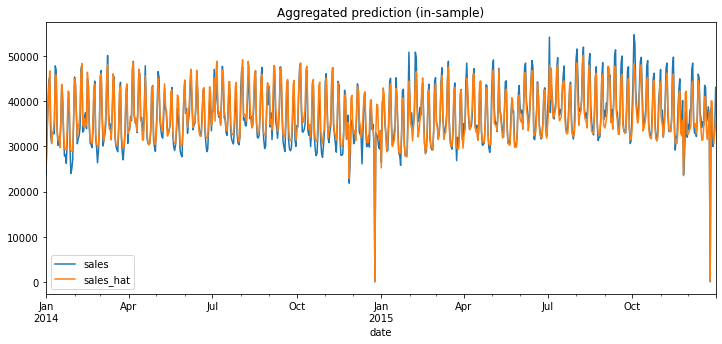

In [106]:
xy1_agg = xy1_hat[['sales', 'sales_hat']].groupby("date").sum(...)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Aggregated prediction (in-sample)")
xy1_agg.to_dataframe().plot.line(ax=ax)
fig;

### Validate

Validation set: all known dates in 2016

In [107]:
xy2 = ds.sel(date=slice("2016-01-01", None))

In [108]:
xy2_hat = mdl.transform(xy2)

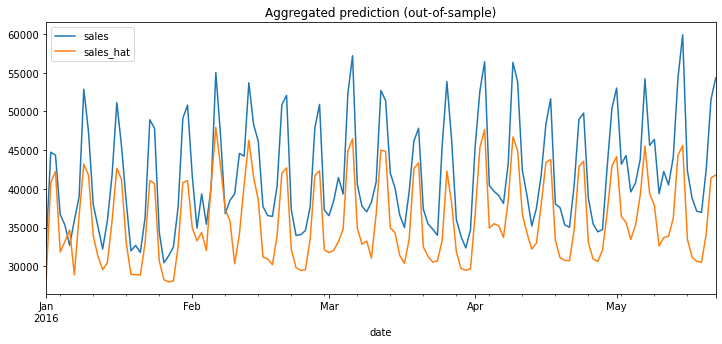

In [109]:
xy2_agg = xy2_hat[['sales', 'sales_hat']].groupby("date").sum(...)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Aggregated prediction (out-of-sample)")
xy2_agg.to_dataframe().plot.line(ax=ax)
fig;

### Calculate error

The denominator is the MSE for the naive (1-step-ahead) forecast:

$$
mse_{naive} = \frac{1}{n-1} \sum_{t=2}^{n}{(Y_t-Y_{t-1})^2}
$$

We calculate error only after the first non-zero demand was observed.

The numerator is the MSE of your prediction, on the validation set:

$$
mse_{pred} = \frac{1}{h} \sum_{t=n+1}^{n+h} {(Y_t - \hat{Y_t})^2}
$$


The weights are just the value of sales during the last 28 days:

$$
w_i = \sum_{t=n-27}^{n}{Y_t \cdot price_t}
$$

Putting it all together, we get the Root Mean Squared Scaled Error (RMSSE):

$$
RMSSE = \sqrt{\frac{mse_{pred}}{mse_{naive}}}
$$

The weights are used to calculate the final metric (over all series):

$$
WRMSSE = \sum_{i=1}^{42840} {w_i * RMSSE_i}
$$

In [110]:
get_wrmsse(xy1, xy2_hat, t_hat="sales_hat")

0.9584975258487616

Note that an error greater than 1 means the forecast is worse than a 1-step-ahead naive/random walk forecast.
However, a 1-step-ahead forecast is impossible to use, because the forecast period is more than 1 day ahead.

In [133]:
errors_per_level = wrmsse_per_level(xy1, xy2_hat, t_hat="sales_hat")

In [134]:
errors_per_level.to_frame("Weighted RMSSE")

,Weighted RMSSE
total,1.014906
state,1.053638
store,0.958498
cat,0.956526
dept,1.010660
state-cat,0.940062
state-dept,1.003894
store-cat,0.956526
store-dept,1.010660
product,0.958498


This is the final error that would be shown on the leaderboard:

In [112]:
# result = wrmsse_total(xy1, xy2_hat, t_hat="sales_hat")
result = errors_per_level.mean()
result

0.98966696405627

## Investigate model

### Importance

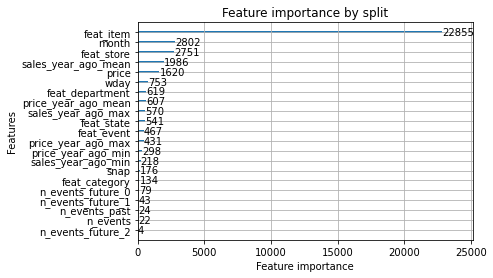

In [113]:
lgb.plot_importance(mdl.sk_obj, importance_type="split", title="Feature importance by split");

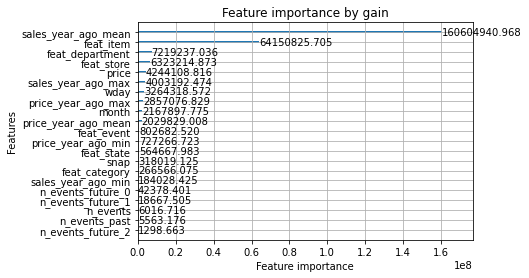

In [114]:
lgb.plot_importance(mdl.sk_obj, importance_type="gain", title="Feature importance by gain");

### SHAP

Prepare data for SHAP. **TODO**: Allow low-level control over dataframe in wrapper!

In [115]:
from nd_learn.compat.sklearn.wrap import _selection_helper_df
ds = xy2
self = mdl
predictor_vars = self.predictors.select(ds)
dims_obs = self.dims_obs
obs_coords = ds[dims_obs].stack({"obs": dims_obs})["obs"]

X: pd.DataFrame = _selection_helper_df(
    ds=ds,
    dims_obs=dims_obs,
    selected_vars=predictor_vars,
    obs_coords=obs_coords,
)
Xs = X.sample(1000, random_state=42)

Import and init shap.

In [116]:
import shap

In [117]:
shap.initjs()

In [118]:
explainer = shap.TreeExplainer(mdl.sk_obj, feature_names=Xs.columns)

In [119]:
shap_values = explainer.shap_values(Xs)

In [120]:
sv = explainer(Xs)

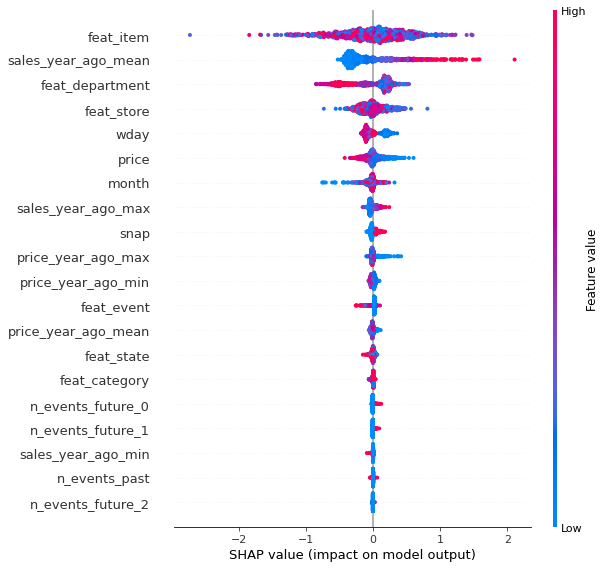

In [121]:
shap.summary_plot(shap_values, Xs)

In [122]:
# shap.force_plot(explainer.expected_value, shap_values[0:], Xs)

#### Estimation

In [188]:
import statsmodels.api as sm

price_shap = sv[:, "price"].values
price_vals = sv[:, "price"].data
_reg = sm.OLS(price_shap, sm.add_constant(np.log(price_vals))).fit()
_preds = pd.Series(_reg.predict(sm.add_constant(np.log(price_vals))), index=price_vals).sort_index()

_p0, _p1 = _reg.params
_s = "+" if _p1 > 0 else "-"

_reg_formula = f"{_p0:.2f} {_s} {np.abs(_p1):.2f} log(price)"

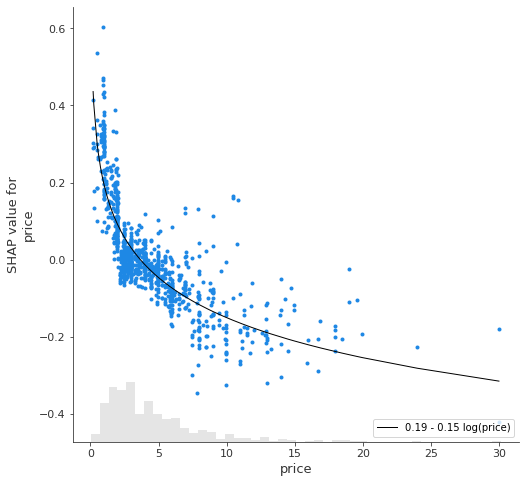

In [195]:
fig, ax = plt.subplots(figsize=(8, 8))
# ax.set_yscale('log')
ax.set_xscale('linear')
ax.plot(_preds.index, _preds.values, color='black', linewidth=1, label=_reg_formula)
ax.legend(loc="lower right")
ax.set_xlabel("price (log scale)")
shap.plots.scatter(sv[:, "price"], ax=ax)
fig;

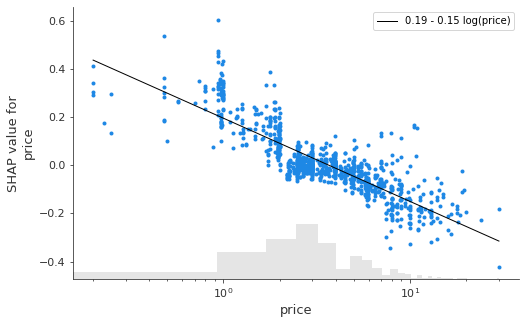

In [196]:
fig, ax = plt.subplots(figsize=(8, 5))
# ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(_preds.index, _preds.values, color='black', linewidth=1, label=_reg_formula)
ax.legend()
ax.set_xlabel("price (log scale)")
shap.plots.scatter(sv[:, "price"], ax=ax)
fig;

In [124]:
shap.force_plot(explainer.expected_value, shap_values[0], Xs.iloc[0])

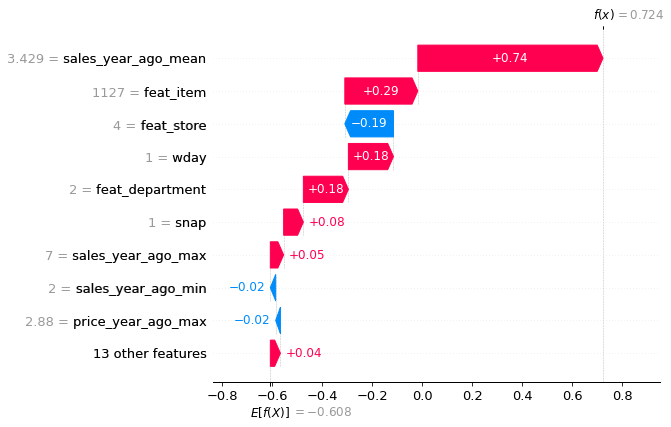

In [125]:
shap.waterfall_plot(sv[0])

### Simulation

In [127]:
pcts = np.arange(0.9, 1.1, step=0.0025)
preds = pd.DataFrame(index=Xs.index)
for mult in pcts:
    Xd = Xs.copy()
    Xd['price'] = Xs['price'] * mult
    preds[mult] = mdl.sk_obj.predict(Xd)

In [128]:
base_pred = pd.Series(mdl.sk_obj.predict(Xs), index=Xs.index)

In [129]:
dlogy = preds.sub(base_pred, axis='rows').div(base_pred, axis='rows')
dlogx = pd.Series(pcts-1, index=pcts)
elasts_raw = dlogy.div(dlogx, axis='columns')
del elasts_raw[pcts[(len(pcts)-1)//2]]

In [130]:
elast_avg_per_change = elasts_raw.mean()

elast_std_per_change = elasts_raw.std()
elast_avg_global = elast_avg_per_change.mean()

In [131]:
from scipy import stats
_x = stats.norm.ppf(0.75)

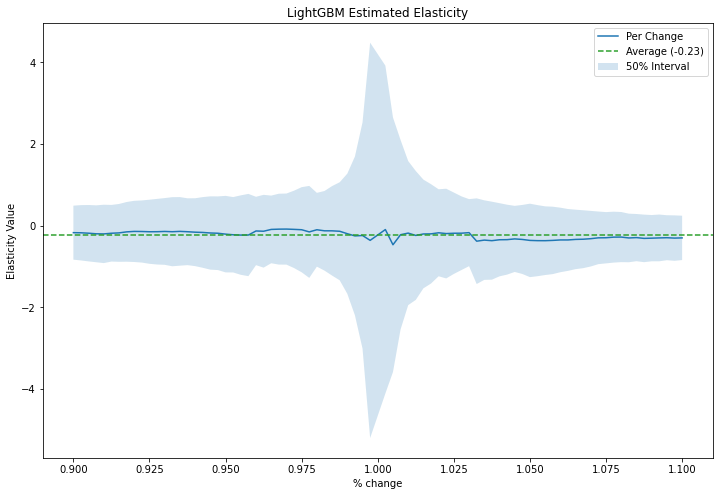

In [132]:
fig, ax = plt.subplots(figsize=(12, 8))
elasts_raw.mean().plot.line(ax=ax, label="Per Change")

ax.axhline(elast_avg_global, label=f"Average ({elast_avg_global:.2f})", color="C2", linestyle="--")
ax.fill_between(
    elast_avg_per_change.index,
    elast_avg_per_change - _x * elast_std_per_change,
    elast_avg_per_change + _x * elast_std_per_change,
    alpha=0.2,
    label="50% Interval",
)
ax.set_title("LightGBM Estimated Elasticity")
ax.set_xlabel("% change")
ax.set_ylabel("Elasticity Value")
ax.legend()
fig;